<a id="top"></a>

The purpose of this notebook is to train and test a predictive model for route 46A.  
The model should take in a variety of features (including time, day, weather) and should calculate the predicted journey time for the bus route.

***

# Import Packages

In [2]:
import pandas as pd
import sqlite3
import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 

import pickle

***

<a id="contents"></a>
# Contents

- [1. Load in the Data](#load_in_the_data)
  
  
- [2. Data Understanding and Preparation](#data_understanding_and_preparation)
    - [2.1. Splitting Dataset into Training and Test Sets](#splitting)
    - [2.2. On the Training Set](#on_training_set)
        - [2.2.1. Correlations between Continuous Features](#2.2.1.)
        - [2.2.2. Continuous Features Interaction with Target Feature](#2.2.2.)
        - [2.2.3. Promising Continuous Features](#2.2.3.)
        - [2.2.4. Categorical Feature Pairwise Interactions with Target Feature](#2.2.4.)
        - [2.2.5. Promising Categorical Features](#2.2.5.)
        - [2.2.6. Transforming Features](#2.2.6.)
       
       
- [3. Linear Regression](#3)
    - [3.1. Linear Regression Model](#3.1)
    - [3.2. Coefficients of the Model](#3.2)
    - [3.3. Predicted Target Feature Value](#3.3)
    - [3.4. Model Evaluation](#3.4)
  
  
- [4. Linear Regression - Replace 'weather_description' with 'weather_main'](#4)
    - [4.1. Linear Regression Model](#4.1)
    - [4.2. Coefficients of the Model](#4.2)
    - [4.3. Predicted Target Feature Value](#4.3)
    - [4.4. Model Evaluation](#4.4)

***

<a id="load_in_the_data"></a>
# 1. Load in the Data
[Back to contents](#contents)

#### Data Base Connection

In [3]:
# def function to create connection to db
def create_connection(db_file):
    """
    create a database connection to the SQLite database specified by db_file
    :param df_file: database file
    :return: Connection object or None
    """
    conn = None
    try: 
        conn = sqlite3.connect(db_file)
        return conn
    except 'Error' as e:
        print(e)
        
    return conn

In [4]:
# create connection to db
db_file = '/home/faye/Data-Analytics-CityRoute/dublinbus.db'
conn = create_connection(db_file)

## 1.1. Bus Data - Line 46A

For line 46A we will be using routes 46A_67 and 46A_74 as these are the routes with the largest number of stops.  
_67 is inbound, _74 is outbound

#### Old Query

In [4]:
# initialise query
#bus_query = """
#SELECT *
#FROM leavetimes
#WHERE TRIPID in 
#    (
#    SELECT TRIPID 
#    FROM trips
#    WHERE ROUTEID = '46A_74'
#    )
#"""

In [5]:
# initialise query
bus_query = """
SELECT T.*, W.*
FROM trips2 T, weather W
WHERE ROUTEID = '46A_74' and T.dt = W.dt
"""

In [30]:
# read in query
df = pd.read_sql(bus_query, conn)

In [31]:
# change hour to numerical
df['HOUR'] = df['HOUR'].astype('int64')

In [32]:
# drop index column
df = df.drop(columns=['index'])

#### Overview

In [10]:
# Print the number of rows and features in the dataset
num_rows = df.shape[0]
features = df.shape[1]
print(f"The dataset has {num_rows} rows with {features} features.")

The dataset has 34326 rows with 30 features.


In [11]:
# print first 5 rows
df.head(5)

,index,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,...,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,weather_id,weather_main,weather_description
0,2090887,2018-01-01 00:00:00.000000,5955569,46A,46A_74,1,50128,46200,49566,46227,...,7.01,994,76,12.35,270,0.0,75,803,Clouds,broken clouds
1,2093439,2018-01-01 00:00:00.000000,5955571,46A,46A_74,1,60188,56400,59006,56346,...,6.63,999,87,11.83,290,0.0,75,520,Rain,light intensity shower rain
2,2079285,2018-01-01 00:00:00.000000,5955573,46A,46A_74,1,69726,66000,69222,65929,...,5.22,1004,87,6.69,280,0.0,20,801,Clouds,few clouds
3,2079286,2018-01-01 00:00:00.000000,5955575,46A,46A_74,1,77691,74700,77630,74693,...,5.14,1007,81,8.23,260,0.0,40,802,Clouds,scattered clouds
4,2075883,2018-01-01 00:00:00.000000,5955577,46A,46A_74,1,86691,83700,86381,83679,...,4.18,1008,75,7.20,260,0.0,40,802,Clouds,scattered clouds


In [12]:
# print last 5 rows
df.tail(5)

,index,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,...,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,weather_id,weather_main,weather_description
34321,484863,2018-12-31 00:00:00.000000,8589277,46A,46A_74,1,74009,70200,73907,70192,...,9.65,1034,76,4.1,260,0.0,75,803,Clouds,broken clouds
34322,471586,2018-12-31 00:00:00.000000,8590431,46A,46A_74,1,30614,27900,31064,27894,...,8.95,1034,81,3.1,230,0.0,75,803,Clouds,broken clouds
34323,36986,2018-12-31 00:00:00.000000,8590433,46A,46A_74,1,40146,36600,40476,36718,...,9.41,1034,81,3.1,220,0.0,75,803,Clouds,broken clouds
34324,11897,2018-12-31 00:00:00.000000,8590435,46A,46A_74,1,51076,47400,51252,47341,...,9.85,1034,71,4.1,230,0.0,75,803,Clouds,broken clouds
34325,26108,2018-12-31 00:00:00.000000,8590437,46A,46A_74,1,62755,58800,63236,58774,...,9.49,1034,71,4.6,240,0.0,75,803,Clouds,broken clouds


#### Missing Values

In [18]:
# print number of missing values for each feature
df.isnull().sum()

DAYOFSERVICE           0
TRIPID                 0
LINEID                 0
ROUTEID                0
DIRECTION              0
PLANNEDTIME_ARR        0
PLANNEDTIME_DEP        0
ACTUALTIME_ARR         0
ACTUALTIME_DEP         0
LASTUPDATE             0
PLANNEDTIME_TRAVEL     0
ACTUALTIME_TRAVEL      0
dt                     0
MONTHOFSERVICE         0
DAYOFWEEK              0
HOUR                   0
IS_HOLIDAY             0
dt                     0
temp                   0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
dtype: int64

In [12]:
# drop rows with missing values
#df_outbound.dropna(how='any', inplace=True)

##### Datatypes

In [19]:
# print data types of each feature
df.dtypes

DAYOFSERVICE            object
TRIPID                  object
LINEID                  object
ROUTEID                 object
DIRECTION               object
PLANNEDTIME_ARR          int64
PLANNEDTIME_DEP          int64
ACTUALTIME_ARR           int64
ACTUALTIME_DEP           int64
LASTUPDATE              object
PLANNEDTIME_TRAVEL       int64
ACTUALTIME_TRAVEL        int64
dt                      object
MONTHOFSERVICE          object
DAYOFWEEK               object
HOUR                     int64
IS_HOLIDAY              object
dt                      object
temp                   float64
pressure                 int64
humidity                 int64
wind_speed             float64
wind_deg                 int64
rain_1h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
dtype: object

In [33]:
# select date features
datetime_features = df[[
    'DAYOFSERVICE', 'dt'
]].columns

for c in datetime_features:
    df[c] = df[c].astype('datetime64')

In [34]:
# select categorical features
categorical_features = df[[
    'TRIPID', 'LINEID', 'ROUTEID', 'DIRECTION',
    'MONTHOFSERVICE', 'DAYOFWEEK', 'HOUR', 'IS_HOLIDAY'
]].columns

for c in categorical_features:
    df[c] = df[c].astype('category')

In [16]:
# # select continuous features
# continuous_features = df_outbound[[
#     'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP',
#     'ACTUALTIME_ARR', 'ACTUALTIME_DEP'
# ]].columns

# for c in continuous_features: 
#     df_outbound[c] = df_outbound[c].astype('int64')

In [117]:
# print data types of each feature
df_outbound.dtypes

DAYOFSERVICE          datetime64[ns]
TRIPID                      category
LINEID                      category
ROUTEID                     category
DIRECTION                   category
PLANNEDTIME_ARR                int64
PLANNEDTIME_DEP                int64
ACTUALTIME_ARR                 int64
ACTUALTIME_DEP                 int64
PLANNEDTIME_TRAVEL             int64
ACTUALTIME_TRAVEL              int64
dt                    datetime64[ns]
MONTHOFSERVICE              category
DAYOFWEEK                   category
HOUR                        category
IS_HOLIDAY                  category
dtype: object

#### Add Target Feature - ACTUALTIME_TRAVEL

In [18]:
# sort sequentially by TRIPID, DAYOFSERVICE, PROGRNUMBER
#df_outbound = df_outbound.sort_values(['DAYOFSERVICE', 'TRIPID'])

In [19]:
# calculate planned travel time
#df_outbound['PLANNEDTIME_TRAVEL'] = (df_outbound['PLANNEDTIME_ARR'] - df_outbound['PLANNEDTIME_DEP'])

In [20]:
# calculate planned travel time
#df_outbound['ACTUALTIME_TRAVEL'] = (df_outbound['ACTUALTIME_ARR'] - df_outbound['ACTUALTIME_DEP'])

#### Add MONTH feature

In [21]:
# add feature MONTHOFSERVICE
#df_outbound['MONTHOFSERVICE'] = df_outbound['DAYOFSERVICE'].dt.strftime('%B')

#### Add DAYOFWEEK feature

In [22]:
# add feature DAYOFWEEK
#df_outbound['DAYOFWEEK'] = [calendar.day_name[val.weekday()] for val in df_outbound['DAYOFSERVICE']]

#### Add datetime feature - for weather query

I will create a datetime feature, 'dt', that combines the DAYOFSERVICE with the hour of departure. This will be used to join the bus data with the weather data.

In [23]:
# initialise 'dt' feature
#df_outbound['dt'] = 0

In [24]:
# create datetime feature combining DAYOFSERVICE and ACTUALTIME_DEP
#for i in range(df_outbound.shape[0]):
#    df_outbound.iloc[i, df_outbound.columns.get_loc('dt')] = datetime.datetime.fromtimestamp(df_outbound['DAYOFSERVICE'].iloc[i].timestamp() + df_outbound['ACTUALTIME_DEP'].iloc[i])

In [25]:
# remove minutes and seconds from dt feature
# new_date = old_date.replace(minute=0, second=0)
#for i in range(df_outbound.shape[0]):
#    df_outbound.iloc[i, df_outbound.columns.get_loc('dt')] = df_outbound['dt'].iloc[i].replace(minute=0, second=0)

In [26]:
# convert dt to datetime
#df_outbound['dt'] = pd.to_datetime(df_outbound['dt'])

In [27]:
# print first 5 rows
#df_outbound.head(5)

,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,ACTUALTIME_TRAVEL,MONTHOFSERVICE,DAYOFWEEK,dt
35577,2018-01-01,5955569,46A,46A_74,1,50128,46200,49566,46227,3339,January,Monday,2018-01-01 12:00:00
35629,2018-01-01,5955571,46A,46A_74,1,60188,56400,59006,56346,2660,January,Monday,2018-01-01 15:00:00
35379,2018-01-01,5955573,46A,46A_74,1,69726,66000,69222,65929,3293,January,Monday,2018-01-01 18:00:00
35380,2018-01-01,5955575,46A,46A_74,1,77691,74700,77630,74693,2937,January,Monday,2018-01-01 20:00:00
35333,2018-01-01,5955577,46A,46A_74,1,86691,83700,86381,83679,2702,January,Monday,2018-01-01 23:00:00


#### Add HOUR feature

In [28]:
#df_outbound['HOUR'] = df_outbound.dt.dt.hour

#### Add IS_HOLIDAY feature

In [29]:
# Getting the Irish holidays - including bank holidays
# https://towardsdatascience.com/5-minute-guide-to-detecting-holidays-in-python-c270f8479387
#irish_holidays_2018 = []
#for date in holidays.Ireland(years=2018).items():
#    irish_holidays_2018.append(str(date[0]))

In [30]:
# add feature IS_HOLIDAY
#df_outbound['IS_HOLIDAY'] = [1 if str(val).split()[0] in irish_holidays_2018 else 0 for val in df_outbound['DAYOFSERVICE']]

#### Check that ACTUALTIME_DEP < ACTUALTIME_ARR

In [31]:
# create a dataframe for check 2
#check_2 = df_outbound[['ACTUALTIME_ARR','ACTUALTIME_DEP']][df_outbound['ACTUALTIME_DEP']>df_outbound['ACTUALTIME_ARR']]
#print(f"Number of rows failing the check: {check_2.shape[0]}")
#check_2

Number of rows failing the check: 1


,ACTUALTIME_ARR,ACTUALTIME_DEP
22613,73720,73729


In [32]:
# drop rows failing check
#df_outbound.drop(index=22613, inplace=True)

In [99]:
#df_outbound.head(5)

,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,ACTUALTIME_TRAVEL,MONTHOFSERVICE,DAYOFWEEK,dt,HOUR,IS_HOLIDAY
35577,2018-01-01,5955569,46A,46A_74,1,50128,46200,49566,46227,3339,January,Monday,2018-01-01 12:00:00,12,1
35629,2018-01-01,5955571,46A,46A_74,1,60188,56400,59006,56346,2660,January,Monday,2018-01-01 15:00:00,15,1
35379,2018-01-01,5955573,46A,46A_74,1,69726,66000,69222,65929,3293,January,Monday,2018-01-01 18:00:00,18,1
35380,2018-01-01,5955575,46A,46A_74,1,77691,74700,77630,74693,2937,January,Monday,2018-01-01 20:00:00,20,1
35333,2018-01-01,5955577,46A,46A_74,1,86691,83700,86381,83679,2702,January,Monday,2018-01-01 23:00:00,23,1


In [100]:
#df_outbound.dtypes

DAYOFSERVICE         datetime64[ns]
TRIPID                     category
LINEID                     category
ROUTEID                    category
DIRECTION                  category
PLANNEDTIME_ARR               int64
PLANNEDTIME_DEP               int64
ACTUALTIME_ARR                int64
ACTUALTIME_DEP                int64
ACTUALTIME_TRAVEL             int64
MONTHOFSERVICE               object
DAYOFWEEK                    object
dt                   datetime64[ns]
HOUR                          int64
IS_HOLIDAY                    int64
dtype: object

## 1.2. Weather Data


In [118]:
# create dt tuple
dt_tuple = tuple(df_outbound.dt.dt.strftime('%Y-%m-%d %H:%M:%S.%f').to_list())

In [119]:
# initialise query
query = f"""
SELECT *
FROM weather
WHERE dt IN {dt_tuple}
"""

In [120]:
# read in query to dataframe
df_weather = pd.read_sql(query, conn)

In [121]:
# remove unnecessary index column
df_weather = df_weather.drop(columns='index')

In [122]:
# print first 5 rows
df_weather

,dt,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,weather_id,weather_main,weather_description
0,2018-01-01 08:00:00.000000,4.05,991,87,6.69,240,0.0,75,803,Clouds,broken clouds
1,2018-01-01 09:00:00.000000,4.08,992,87,7.72,240,0.0,40,802,Clouds,scattered clouds
2,2018-01-01 10:00:00.000000,5.02,992,81,9.77,240,0.0,40,802,Clouds,scattered clouds
3,2018-01-01 11:00:00.000000,6.01,994,81,12.35,260,0.0,40,802,Clouds,scattered clouds
4,2018-01-01 12:00:00.000000,7.01,994,76,12.35,270,0.0,75,803,Clouds,broken clouds
...,...,...,...,...,...,...,...,...,...,...,...
6256,2018-12-31 17:00:00.000000,9.47,1034,71,3.60,240,0.0,75,803,Clouds,broken clouds
6257,2018-12-31 18:00:00.000000,9.19,1034,75,4.60,250,0.0,75,803,Clouds,broken clouds
6258,2018-12-31 19:00:00.000000,9.65,1034,76,4.10,260,0.0,75,803,Clouds,broken clouds
6259,2018-12-31 20:00:00.000000,9.27,1034,81,4.10,250,0.0,75,803,Clouds,broken clouds


In [123]:
# print datatypes
df_weather.dtypes

dt                      object
temp                   float64
pressure                 int64
humidity                 int64
wind_speed             float64
wind_deg                 int64
rain_1h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
dtype: object

In [124]:
# convert 'dt' to datetime
df_weather['dt'] = df_weather['dt'].astype('datetime64')

## 1.3. Create New Dataframe - Combine Bus and Weather

#### Overview of Merged Data

In [ ]:
# print shape of bus data
df_outbound.shape

In [ ]:
# print shape of weather data
df_weather.shape

In [127]:
# merge bus and weather data based on dt feature
df = pd.merge(df_outbound, df_weather, on='dt')

In [35]:
# print the number of rows and features in the dataset
num_rows = df.shape[0]
features = df.shape[1]
print(f"The dataset has {num_rows} rows with {features} features.")

The dataset has 34326 rows with 28 features.


In [25]:
# print the first 5 rows
print("The first 5 Rows are:")
df.head(5)

The first 5 Rows are:


,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LASTUPDATE,...,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,weather_id,weather_main,weather_description
0,2018-01-01,5955569,46A,46A_74,1,50128,46200,49566,46227,2018-01-08 17:21:10.000000,...,7.01,994,76,12.35,270,0.0,75,803,Clouds,broken clouds
1,2018-01-01,5955571,46A,46A_74,1,60188,56400,59006,56346,2018-01-08 17:21:10.000000,...,6.63,999,87,11.83,290,0.0,75,520,Rain,light intensity shower rain
2,2018-01-01,5955573,46A,46A_74,1,69726,66000,69222,65929,2018-01-08 17:21:10.000000,...,5.22,1004,87,6.69,280,0.0,20,801,Clouds,few clouds
3,2018-01-01,5955575,46A,46A_74,1,77691,74700,77630,74693,2018-01-08 17:21:10.000000,...,5.14,1007,81,8.23,260,0.0,40,802,Clouds,scattered clouds
4,2018-01-01,5955577,46A,46A_74,1,86691,83700,86381,83679,2018-01-08 17:21:10.000000,...,4.18,1008,75,7.20,260,0.0,40,802,Clouds,scattered clouds


In [130]:
# print the last 5 rows
print("The last 5 Rows are:")
df.tail(5)

The last 5 Rows are:


,DAYOFSERVICE,TRIPID,LINEID,ROUTEID,DIRECTION,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,PLANNEDTIME_TRAVEL,...,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,weather_id,weather_main,weather_description
34321,2018-12-31,8580475,46A,46A_74,1,76912,73800,77395,73764,3112,...,9.27,1034,81,4.1,250,0.0,75,803,Clouds,broken clouds
34322,2018-12-31,8585311,46A,46A_74,1,76709,72900,76780,72873,3809,...,9.27,1034,81,4.1,250,0.0,75,803,Clouds,broken clouds
34323,2018-12-31,8589246,46A,46A_74,1,75809,72000,75529,72002,3809,...,9.27,1034,81,4.1,250,0.0,75,803,Clouds,broken clouds
34324,2018-12-31,8586161,46A,46A_74,1,81412,78300,81006,78272,3112,...,9.31,1034,81,5.1,260,0.0,75,803,Clouds,broken clouds
34325,2018-12-31,8588976,46A,46A_74,1,79612,76500,80039,76491,3112,...,9.31,1034,81,5.1,260,0.0,75,803,Clouds,broken clouds


In [26]:
# print number of unique values for each feature
df.nunique()

DAYOFSERVICE             360
TRIPID                 10925
LINEID                     1
ROUTEID                    1
DIRECTION                  1
PLANNEDTIME_ARR         6437
PLANNEDTIME_DEP          255
ACTUALTIME_ARR         26095
ACTUALTIME_DEP         21292
LASTUPDATE               360
PLANNEDTIME_TRAVEL       671
ACTUALTIME_TRAVEL       3867
dt                      6238
MONTHOFSERVICE            12
DAYOFWEEK                  7
HOUR                      19
IS_HOLIDAY                 2
dt                      6238
temp                    2007
pressure                  63
humidity                  63
wind_speed                82
wind_deg                  45
rain_1h                    8
clouds_all                80
weather_id                20
weather_main               8
weather_description       21
dtype: int64

In [36]:
# drop constant columns
df = df.drop(columns=['LINEID','ROUTEID','DIRECTION'])

In [37]:
# print the datatype of each feature
df.dtypes

DAYOFSERVICE           datetime64[ns]
TRIPID                       category
PLANNEDTIME_ARR                 int64
PLANNEDTIME_DEP                 int64
ACTUALTIME_ARR                  int64
ACTUALTIME_DEP                  int64
LASTUPDATE                     object
PLANNEDTIME_TRAVEL              int64
ACTUALTIME_TRAVEL               int64
dt                     datetime64[ns]
MONTHOFSERVICE               category
DAYOFWEEK                    category
HOUR                         category
IS_HOLIDAY                   category
dt                     datetime64[ns]
temp                          float64
pressure                        int64
humidity                        int64
wind_speed                    float64
wind_deg                        int64
rain_1h                       float64
clouds_all                      int64
weather_id                      int64
weather_main                   object
weather_description            object
dtype: object

In [38]:
# print the number of null values for each feature
df.isna().sum()

DAYOFSERVICE           0
TRIPID                 0
PLANNEDTIME_ARR        0
PLANNEDTIME_DEP        0
ACTUALTIME_ARR         0
ACTUALTIME_DEP         0
LASTUPDATE             0
PLANNEDTIME_TRAVEL     0
ACTUALTIME_TRAVEL      0
dt                     0
MONTHOFSERVICE         0
DAYOFWEEK              0
HOUR                   0
IS_HOLIDAY             0
dt                     0
temp                   0
pressure               0
humidity               0
wind_speed             0
wind_deg               0
rain_1h                0
clouds_all             0
weather_id             0
weather_main           0
weather_description    0
dtype: int64

In [39]:
df.keys()

Index(['DAYOFSERVICE', 'TRIPID', 'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP',
       'ACTUALTIME_ARR', 'ACTUALTIME_DEP', 'LASTUPDATE', 'PLANNEDTIME_TRAVEL',
       'ACTUALTIME_TRAVEL', 'dt', 'MONTHOFSERVICE', 'DAYOFWEEK', 'HOUR',
       'IS_HOLIDAY', 'dt', 'temp', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'rain_1h', 'clouds_all', 'weather_id', 'weather_main',
       'weather_description'],
      dtype='object')

In [44]:
# Select columns containing categorical data
categorical_features = df[[
    'TRIPID', 'MONTHOFSERVICE', 'DAYOFWEEK', 'HOUR', 'IS_HOLIDAY',
    'weather_id', 'weather_main', 'weather_description'
]].columns

# convert to type category
for c in categorical_features:
    df[c] = df[c].astype('category')

In [41]:
# Select columns containing continous data
continuous_features = df[[
    'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP', 'ACTUALTIME_ARR', 'ACTUALTIME_DEP',
    'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 
    'clouds_all',
]].columns

In [42]:
# print range of target feature - ACTUALTIME_TRAVEL
target_range = df.ACTUALTIME_TRAVEL.max() - df.ACTUALTIME_TRAVEL.min()
print(f"{target_range} seconds")
print(datetime.timedelta(seconds=int(target_range)))

12119 seconds
3:21:59


***

<a id="data_understanding_and_preparation"></a>
# 2. Data Understanding and Preparation
[Back to contents](#contents)

Exploring relationships between feature pairs and selecting/transforming promising features basaed on a given training set.

<a id="splitting"></a>
## 2.1. Splitting Dataset into Training and Test Sets
[Top of section](#data_understanding_and_preparation)

In [61]:
# Randomly shuffle the rows of the dataset and split into train/test, 70/30
X = df[[
    'DAYOFSERVICE', 'TRIPID', 'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP',
    'ACTUALTIME_ARR', 'ACTUALTIME_DEP', 'PLANNEDTIME_TRAVEL', 
    'MONTHOFSERVICE', 'DAYOFWEEK', 'dt', 'HOUR', 'IS_HOLIDAY', 'temp', 
    'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 
    'clouds_all', 'weather_id', 'weather_main', 'weather_description']]
y = df[['ACTUALTIME_TRAVEL']]

# Random state set to 1 so split is always the same
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1, shuffle=True)

In [62]:
# print row split
print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  34326
training range (70%):	 rows 0 to 24028
test range (30%): 	 rows 24028 to 34326


<a id="on_training_set"></a>
## 2.2. On the Training Set
[Top of section](#data_understanding_and_preparation)

<a id="2.2.1."></a>
### 2.2.1. Correlations between Continuous Features
[^](#on_training_set)

#### Correlation Matrix

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0.5, 0, 'PLANNEDTIME_ARR'),
  Text(1.5, 0, 'PLANNEDTIME_DEP'),
  Text(2.5, 0, 'ACTUALTIME_ARR'),
  Text(3.5, 0, 'ACTUALTIME_DEP'),
  Text(4.5, 0, 'temp'),
  Text(5.5, 0, 'pressure'),
  Text(6.5, 0, 'humidity'),
  Text(7.5, 0, 'wind_speed'),
  Text(8.5, 0, 'wind_deg'),
  Text(9.5, 0, 'rain_1h'),
  Text(10.5, 0, 'clouds_all')])

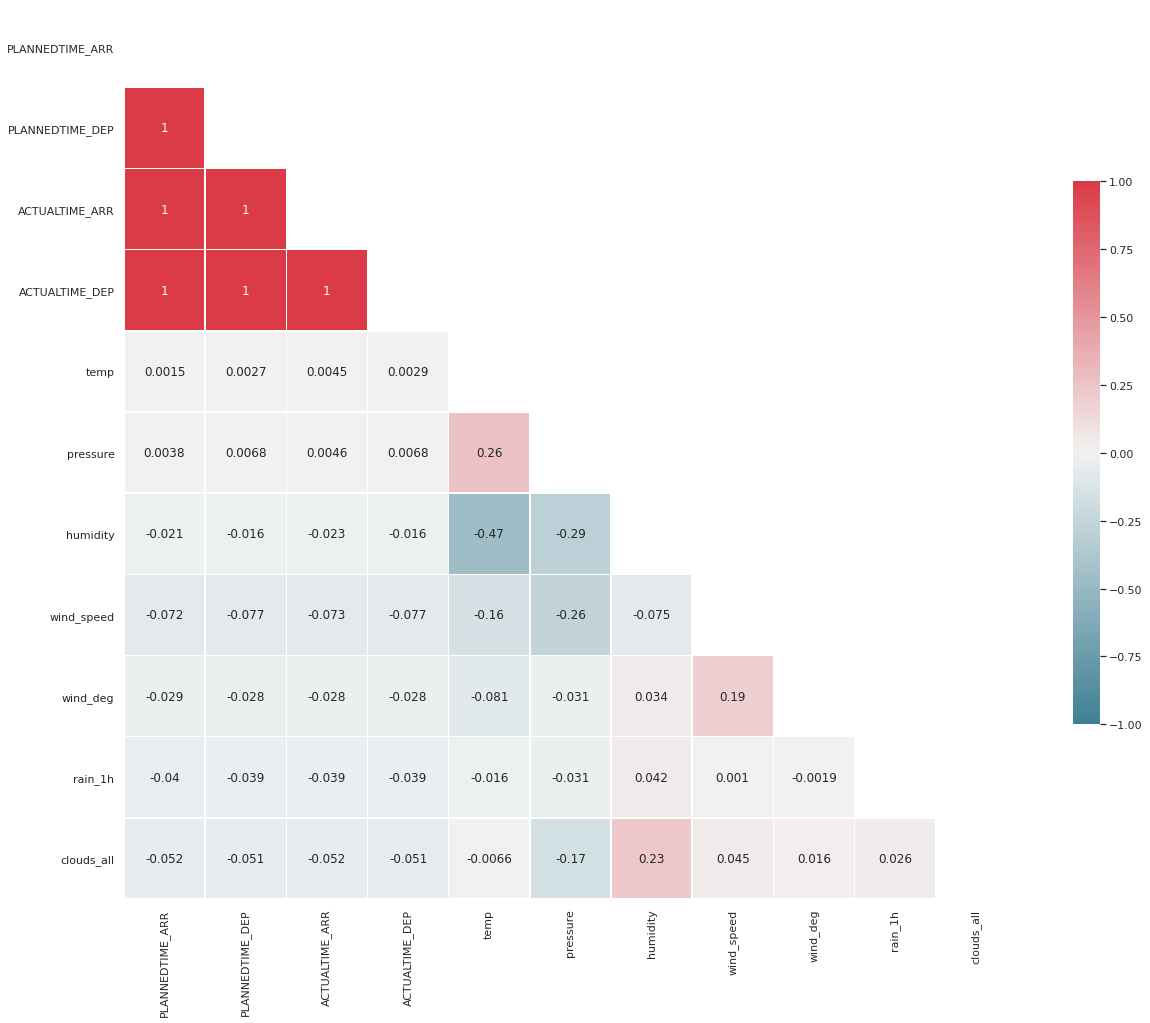

In [56]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")

# Calculate correlation of all pairs of continuous features
corr = X_train[continuous_features].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)

#### Datetime Feature

In [57]:
# Plot datetime feature against target feature
X_train.DAYOFSERVICE = pd.to_numeric(X_train.DAYOFSERVICE)
df_temp = pd.concat([X_train['DAYOFSERVICE'], y_train], axis=1)
correlation_dt = df_temp[['DAYOFSERVICE', 'ACTUALTIME_TRAVEL']].corr(method='pearson')
correlation_dt

/home/faye/.local/lib/python3.6/site-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,DAYOFSERVICE,ACTUALTIME_TRAVEL
DAYOFSERVICE,1.000000,0.034391
ACTUALTIME_TRAVEL,0.034391,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='DAYOFSERVICE', ylabel='ACTUALTIME_TRAVEL'>

<Figure size 432x288 with 0 Axes>

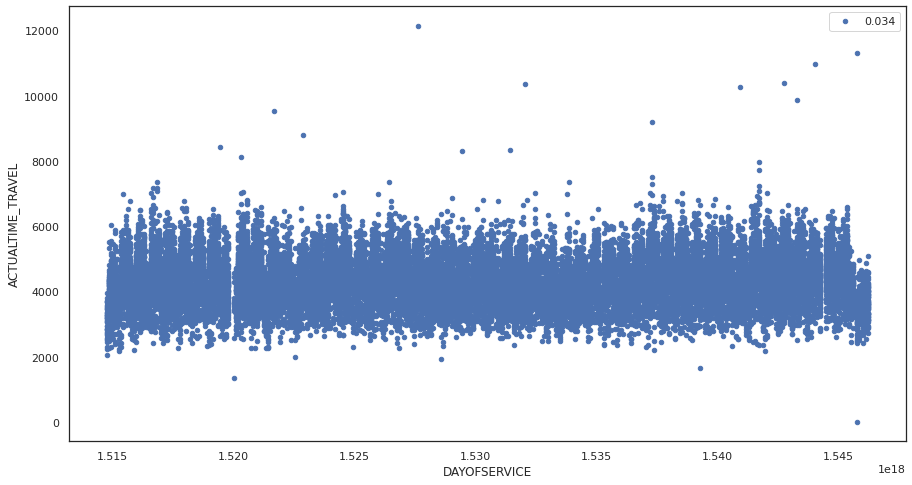

In [58]:
fig = plt.figure()
ax = fig.add_subplot
df_temp.plot(kind='scatter', x='DAYOFSERVICE', y='ACTUALTIME_TRAVEL', label = "%.3f" % df_temp[['ACTUALTIME_TRAVEL', 'DAYOFSERVICE']].corr().to_numpy()[0,1], figsize=(15, 8))

#### Pearson Correlation

In [59]:
# print Pearson correlation between continous features and target feature
for column in continuous_features:
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    correlation_dt = df_temp[[column, 'ACTUALTIME_TRAVEL']].corr(method='pearson')
    print('\n',correlation_dt)


                    PLANNEDTIME_ARR  ACTUALTIME_TRAVEL
PLANNEDTIME_ARR           1.000000          -0.222663
ACTUALTIME_TRAVEL        -0.222663           1.000000

                    PLANNEDTIME_DEP  ACTUALTIME_TRAVEL
PLANNEDTIME_DEP           1.000000          -0.244385
ACTUALTIME_TRAVEL        -0.244385           1.000000

                    ACTUALTIME_ARR  ACTUALTIME_TRAVEL
ACTUALTIME_ARR           1.000000          -0.200895
ACTUALTIME_TRAVEL       -0.200895           1.000000

                    ACTUALTIME_DEP  ACTUALTIME_TRAVEL
ACTUALTIME_DEP           1.000000          -0.245262
ACTUALTIME_TRAVEL       -0.245262           1.000000

                       temp  ACTUALTIME_TRAVEL
temp               1.00000            0.03418
ACTUALTIME_TRAVEL  0.03418            1.00000

                    pressure  ACTUALTIME_TRAVEL
pressure           1.000000          -0.048661
ACTUALTIME_TRAVEL -0.048661           1.000000

                    humidity  ACTUALTIME_TRAVEL
humidity          

<a id="2.2.2."></a>
### 2.2.2. Continuous Features Interaction with Target Feature
[^](#on_training_set)

#### Interaction with Target Feature

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,ACTUALTIME_TRAVEL
wind_speed,0.113450
temp,0.034180
wind_deg,0.016805
rain_1h,0.003781
clouds_all,-0.003733
pressure,-0.048661
humidity,-0.143541
ACTUALTIME_ARR,-0.200895
PLANNEDTIME_ARR,-0.222663
PLANNEDTIME_DEP,-0.244385


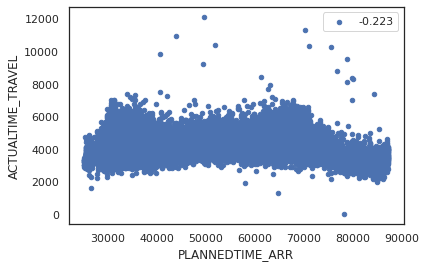

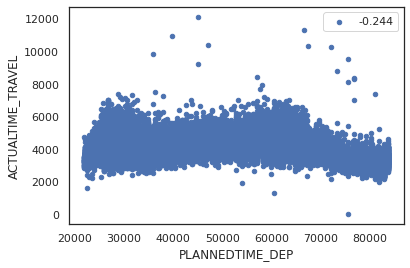

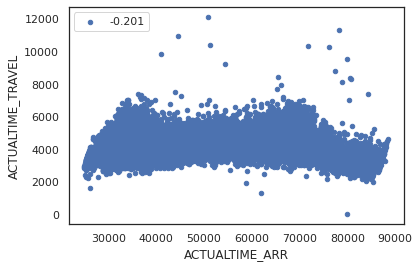

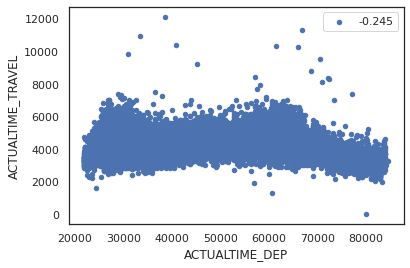

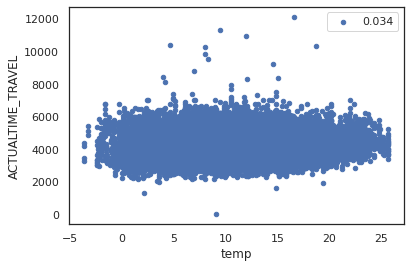

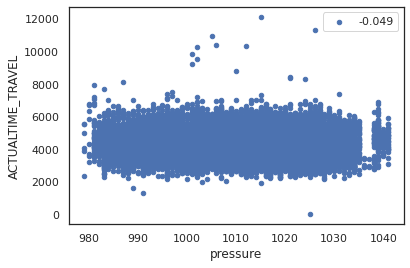

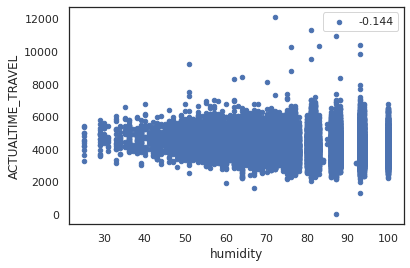

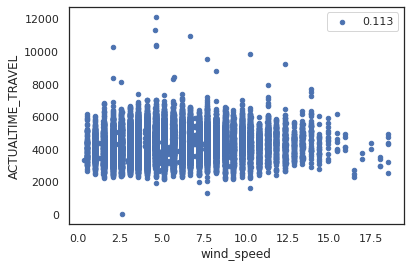

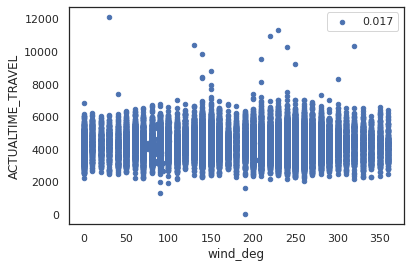

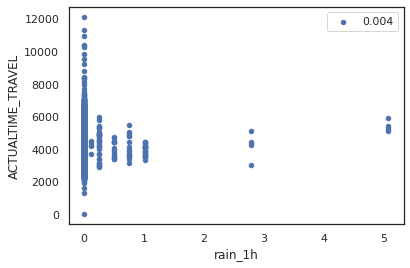

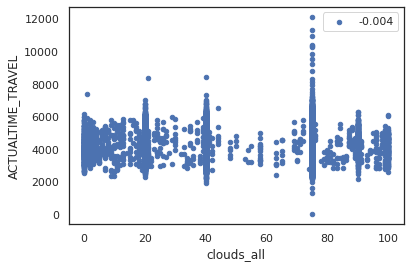

In [60]:
# dict to hold correlation values 
corr_dict = {}

# plot pairwise interaction between all continuous features and target
for column in X_train[continuous_features]:
    # create temp df to merge column and target
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    # store correlation in variable
    correlation = df_temp[[column, "ACTUALTIME_TRAVEL"]].corr().values[0,1]
    # plot the column and tartget feature
    df_temp.plot(kind='scatter', x=column, y="ACTUALTIME_TRAVEL", label="%.3f" % correlation)
    # add correlation to dict
    corr_dict[column] = correlation

# dataframe holding sorted correlation values to aid in interpreting results
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['ACTUALTIME_TRAVEL']).sort_values('ACTUALTIME_TRAVEL', ascending=False)
corr_df

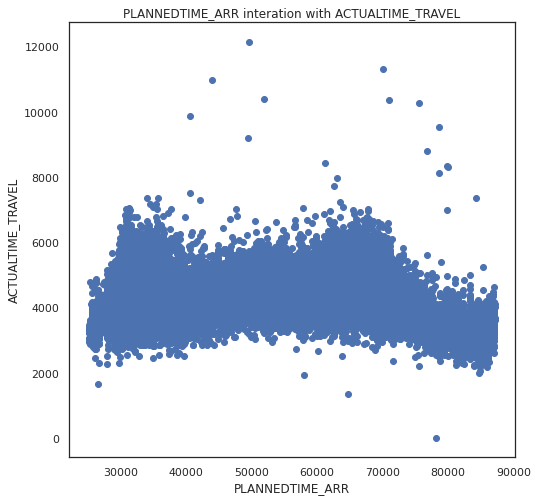

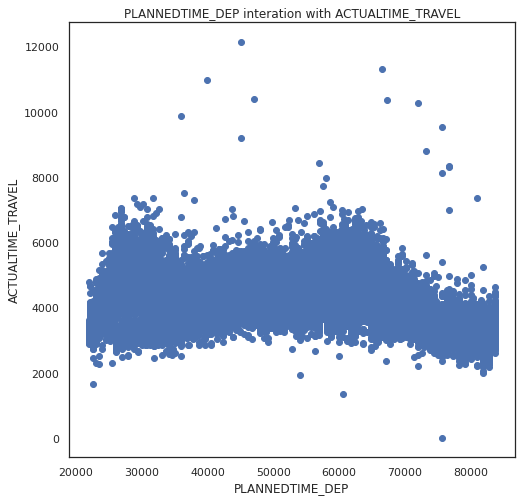

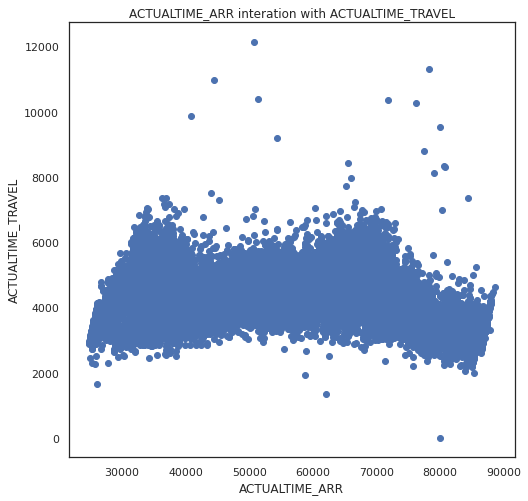

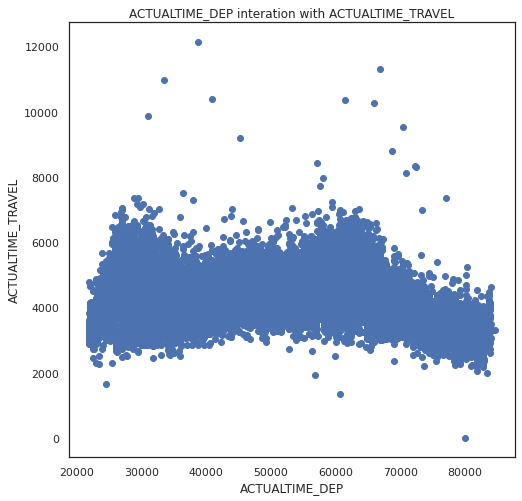

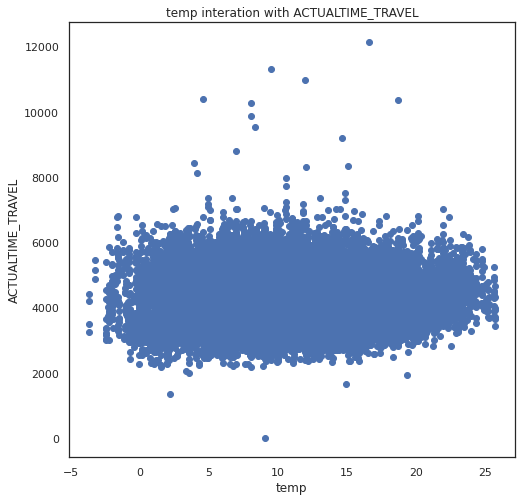

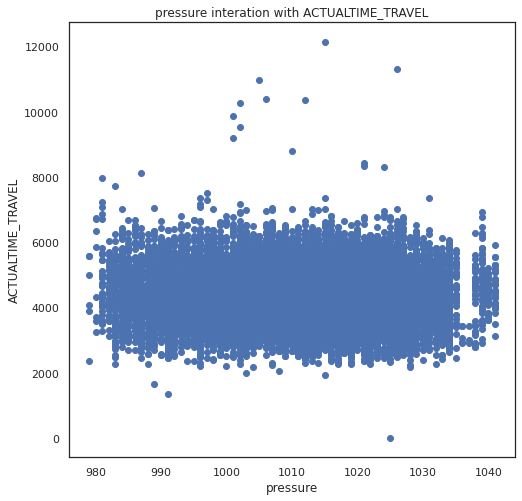

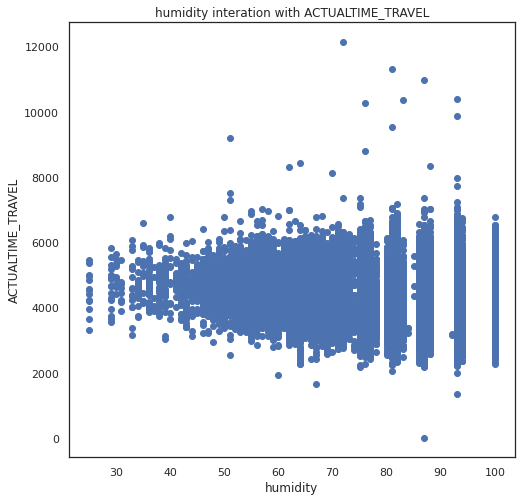

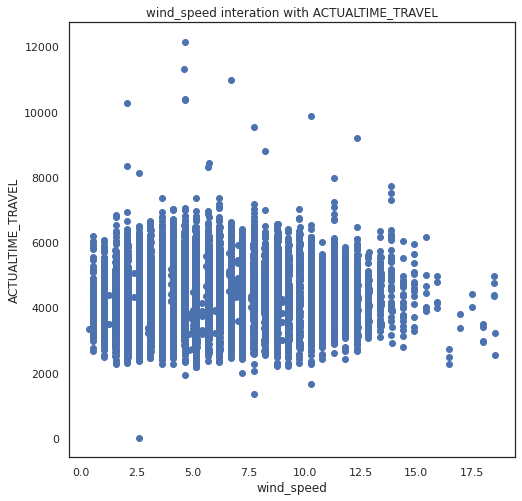

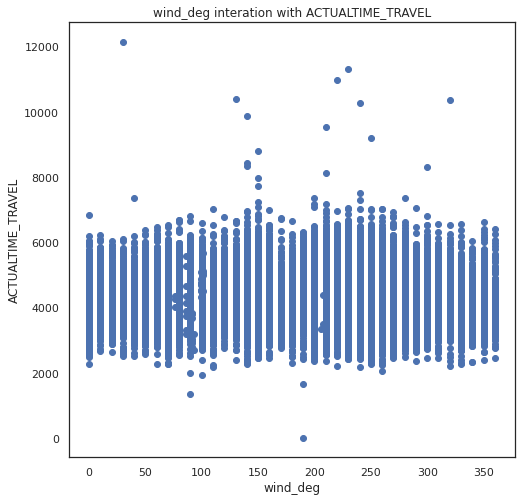

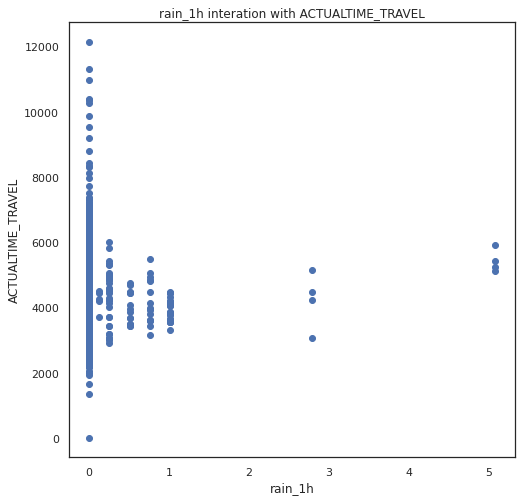

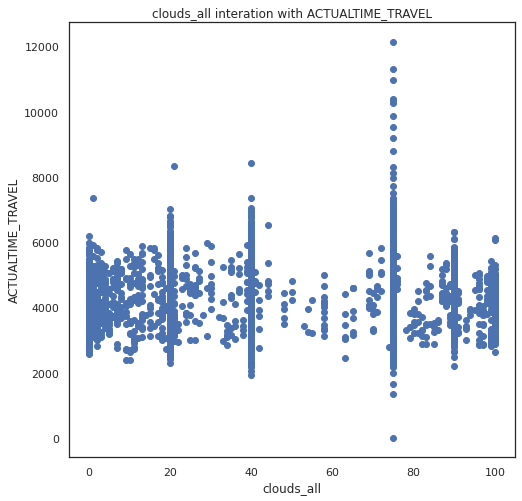

In [61]:
# plot interaction between continuous features and ACTUALTIME_TRAVEL
for c in continuous_features:
    fig, ax = plt.subplots(figsize=(8, 8))

    # Add x-axis and y-axis
    x = X_train[c].values
    y = y_train
    ax.scatter(x, y)
    ax.set_ylabel('ACTUALTIME_TRAVEL')
    ax.set_xlabel(c)
    
    plt.title(f"{c} interation with ACTUALTIME_TRAVEL")
    
    plt.show()

<a id="2.2.3."></a>
### 2.2.3. Promising Continuous Features
[^](#on_training_set)

- hour
- temp
- humidity
- wind_speed
- rain_1h

<a id="2.2.4."></a>
### 2.2.4. Interaction Between Categorical Features and Target Feature
[^](#on_training_set)

In [62]:
categorical_features

Index(['TRIPID', 'MONTHOFSERVICE', 'DAYOFWEEK', 'HOUR', 'weather_id',
       'weather_main', 'weather_description'],
      dtype='object')

In [ ]:
# plot average travel time per Trip ID
df_tripID = df.groupby('TRIPID').mean()

names = df_tripID.index
values = df_tripID['ACTUALTIME_TRAVEL']

plt.bar(names, values)
plt.xticks(rotation=45)
plt.title('Average Travel Time per Trip ID')
plt.xlabel('Trip ID')
plt.ylabel('Actual Travel Time (s)')


plt.show()

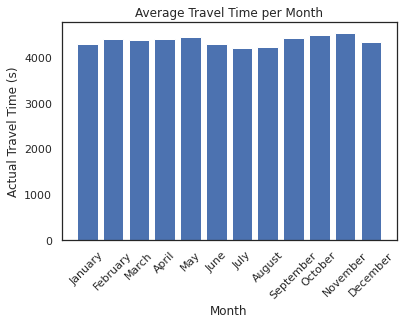

In [63]:
# plot average travel time per month
month_order = [
    'January', 'February', 'March', 'April', 'May', 'June', 
    'July', 'August', 'September', 'October', 'November', 'December'
]

df_months = df.groupby('MONTHOFSERVICE').mean()
df_months = df_months.reindex(month_order)

names = df_months.index
values = df_months['ACTUALTIME_TRAVEL']

plt.bar(names, values)
plt.xticks(rotation=45)
plt.title('Average Travel Time per Month')
plt.xlabel('Month')
plt.ylabel('Actual Travel Time (s)')


plt.show()

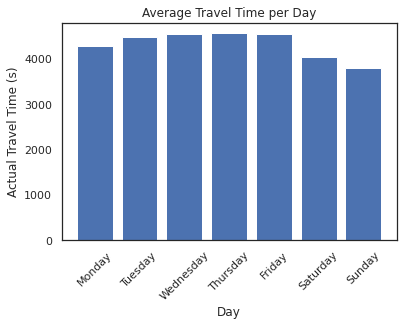

In [64]:
# plot average travel time per day
day_order = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
    'Saturday', 'Sunday'
]

df_days = df.groupby('DAYOFWEEK').mean()
df_days = df_days.reindex(day_order)

names = df_days.index
values = df_days['ACTUALTIME_TRAVEL']

plt.bar(names, values)
plt.xticks(rotation=45)
plt.title('Average Travel Time per Day')
plt.xlabel('Day')
plt.ylabel('Actual Travel Time (s)')


plt.show()

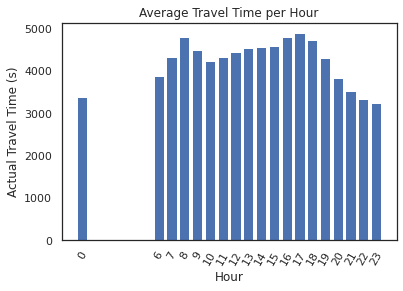

In [65]:
# plot average travel time per hour
hour_order = [
    6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 
    16, 17, 18, 19, 20, 21, 22, 23, 0
]

df_hours = df.groupby('HOUR').mean()
df_hours = df_hours.reindex(hour_order)

names = df_hours.index
values = df_hours['ACTUALTIME_TRAVEL']

plt.bar(names, values)
plt.xticks(hour_order, rotation=60)
plt.title('Average Travel Time per Hour')
plt.xlabel('Hour')
plt.ylabel('Actual Travel Time (s)')

plt.show()

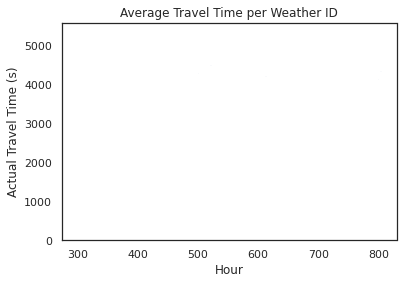

In [97]:
# plot average travel time per weather ID
df_weatherID = df.groupby('weather_id').mean()

names = df_weatherID.index
values = df_weatherID['ACTUALTIME_TRAVEL'].values

plt.bar(names, values)
#plt.xticks(rotation=60)
plt.title('Average Travel Time per Weather ID')
plt.xlabel('Hour')
plt.ylabel('Actual Travel Time (s)')

plt.show()

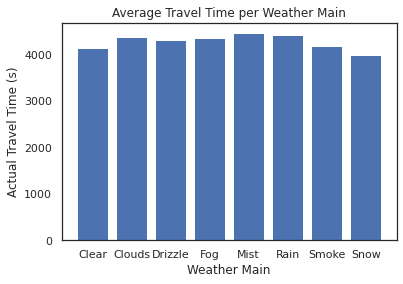

In [95]:
# plot average travel time per Weather Main
df_weather_main = df.groupby('weather_main').mean()

names = df_weather_main.index
values = df_weather_main['ACTUALTIME_TRAVEL'].values

plt.bar(names, values)
#plt.xticks(rotation=60)
plt.title('Average Travel Time per Weather Main')
plt.xlabel('Weather Main')
plt.ylabel('Actual Travel Time (s)')

plt.show()

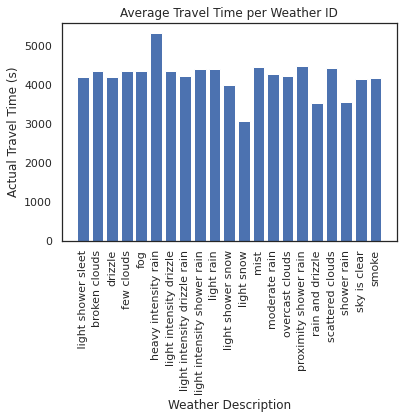

In [94]:
# plot average travel time per Weather Desc
df_weather_desc = df.groupby('weather_description').mean()

names = df_weather_desc.index
values = df_weather_desc['ACTUALTIME_TRAVEL'].values

plt.bar(names, values)
plt.xticks(rotation=90)
plt.title('Average Travel Time per Weather Description')
plt.xlabel('Weather Description')
plt.ylabel('Actual Travel Time (s)')

plt.show()

<a id="2.2.5."></a>
### 2.2.5. Promising Categorical Features
[^](#on_training_set)

- MONTHOFSERVICE
- DAYOFWEEK
- IS_HOLIDAY
- weather_id
- weather_main
- weather_description

<a id="2.2.6."></a>
### 2.2.6. Transforming Features
[^](#on_training_set)

In [101]:
df.dtypes

DAYOFSERVICE           datetime64[ns]
TRIPID                       category
PLANNEDTIME_ARR                 int64
PLANNEDTIME_DEP                 int64
ACTUALTIME_ARR                  int64
ACTUALTIME_DEP                  int64
ACTUALTIME_TRAVEL               int64
MONTHOFSERVICE               category
DAYOFWEEK                    category
dt                     datetime64[ns]
HOUR                         category
IS_HOLIDAY                      int64
temp                          float64
pressure                        int64
humidity                        int64
wind_speed                    float64
wind_deg                        int64
rain_1h                       float64
clouds_all                      int64
weather_id                   category
weather_main                 category
weather_description          category
dtype: object

In [138]:
df.dtypes

DAYOFSERVICE           datetime64[ns]
TRIPID                       category
LINEID                       category
ROUTEID                      category
DIRECTION                    category
PLANNEDTIME_ARR                 int64
PLANNEDTIME_DEP                 int64
ACTUALTIME_ARR                  int64
ACTUALTIME_DEP                  int64
PLANNEDTIME_TRAVEL              int64
ACTUALTIME_TRAVEL               int64
dt                     datetime64[ns]
MONTHOFSERVICE               category
DAYOFWEEK                    category
HOUR                         category
IS_HOLIDAY                   category
temp                          float64
pressure                        int64
humidity                        int64
wind_speed                    float64
wind_deg                        int64
rain_1h                       float64
clouds_all                      int64
weather_id                      int64
weather_main                   object
weather_description            object
dtype: objec

In [142]:
# Making dummy variables for categorical 
cat = ['MONTHOFSERVICE', 'DAYOFWEEK', 'HOUR', 'weather_description', 'IS_HOLIDAY']
df_temp = pd.concat([X_train, y_train], axis=1)
df_copy = df_temp.copy()
df_copy = df_copy[cat]
df_copy = pd.get_dummies(df_copy)
df_copy = pd.concat([df_copy, y_train], axis=1)

categorical_corr = df_copy.corr()['ACTUALTIME_TRAVEL'][:]

In [143]:
categorical_corr

MONTHOFSERVICE_April                0.008396
MONTHOFSERVICE_August              -0.053323
MONTHOFSERVICE_December            -0.012654
MONTHOFSERVICE_February             0.011817
MONTHOFSERVICE_January             -0.028159
                                      ...   
weather_description_sky is clear   -0.045577
weather_description_smoke           0.000454
IS_HOLIDAY_0                        0.136267
IS_HOLIDAY_1                       -0.136267
ACTUALTIME_TRAVEL                   1.000000
Name: ACTUALTIME_TRAVEL, Length: 62, dtype: float64

***

<a id="3"></a>
# 3. Linear Regression
[Back to contents](#contents)

In [48]:
# drop features not being modeled 
features_to_drop = [
    'DAYOFSERVICE', 'TRIPID', 'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP',
    'ACTUALTIME_ARR', 'ACTUALTIME_DEP', 'PLANNEDTIME_TRAVEL',
    'dt', 'pressure', 'wind_deg', 'clouds_all', 'weather_id', 'weather_main'
]

In [49]:
# drop features
X_train = X_train.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)

In [50]:
# get dummies for categorical features
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

<a id="3.1"></a>
## 3.1. Linear Regression Model

In [51]:
# train a linear regression on the training set
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

<a id="3.2"></a>
## 3.2. Coefficients of the Model

In [32]:
# Print the coefficients learned by the model and discuss their role in the model.
print("Features: \n", X_train.columns)
print("\nCoeficients: \n", linear_reg.coef_)
print("\nIntercept: \n", linear_reg.intercept_)

Features: 
 Index(['HOUR', 'temp', 'humidity', 'wind_speed', 'rain_1h',
       'MONTHOFSERVICE_August', 'MONTHOFSERVICE_December',
       'MONTHOFSERVICE_February', 'MONTHOFSERVICE_January',
       'MONTHOFSERVICE_July', 'MONTHOFSERVICE_June', 'MONTHOFSERVICE_March',
       'MONTHOFSERVICE_May', 'MONTHOFSERVICE_November',
       'MONTHOFSERVICE_October', 'MONTHOFSERVICE_September',
       'DAYOFWEEK_Monday', 'DAYOFWEEK_Saturday', 'DAYOFWEEK_Sunday',
       'DAYOFWEEK_Thursday', 'DAYOFWEEK_Tuesday', 'DAYOFWEEK_Wednesday',
       'IS_HOLIDAY_1', 'weather_description_broken clouds',
       'weather_description_drizzle', 'weather_description_few clouds',
       'weather_description_fog', 'weather_description_heavy intensity rain',
       'weather_description_light intensity drizzle',
       'weather_description_light intensity drizzle rain',
       'weather_description_light intensity shower rain',
       'weather_description_light rain',
       'weather_description_light shower snow',
   

<a id="3.3"></a>
## 3.3. Predicted Target Feature Value

In [52]:
# Print the predicted target feature value for the first 10 training examples
linear_reg_predictions = linear_reg.predict(X_train)
print("\nPredictions with linear regression: \n")
actual_vs_predicted_linear_reg = pd.concat([y_train, pd.DataFrame(linear_reg_predictions, columns=['Predicted'], index=y_train.index)], axis=1)
actual_vs_predicted_linear_reg.head(10)


Predictions with linear regression: 



,ACTUALTIME_TRAVEL,Predicted
4574,3857,4540.772246
24283,3820,3840.125105
7771,3637,4075.021653
3397,2945,3918.905682
1529,3468,3560.403154
7775,3987,4556.979748
4645,4577,4699.403583
23038,3266,4217.324324
29884,3342,3441.460360
24461,4545,4889.558612


#### Classification Measures

In [ ]:
# # Print Accuracy
# print('Accuracy: ', metrics.accuracy_score(y_train, linear_reg_predictions) )

# # Print Confusion Matrix
# print('\nConfusion Matrix: \n', metrics.confusion_matrix(y_train, linear_reg_predictions) )

# # Print Classification Report
# print('\nClassification Report: \n', metrics.classification_report(y_train, linear_reg_predictions))

<a id="3.4"></a>
## 3.4. Model Evaluation

In [288]:
# X_test['weather_description_shower rain'] = 0

In [53]:
# Evaluate the model using classification evaluation measures on the hold-out (30%) test set.
linear_reg_predictions_test = (linear_reg.predict(X_test))

# Print predictions
actual_vs_predicted_linear_reg_test = pd.DataFrame(y_test)
actual_vs_predicted_linear_reg_test['Predicted'] = linear_reg_predictions_test
#print("\nPredictions with linear regression on test set: \n")
actual_vs_predicted_linear_reg_test

,ACTUALTIME_TRAVEL,Predicted
25335,4293,4330.407351
30763,4772,4797.280018
3337,3444,3739.704600
24284,3836,4530.148746
29748,3526,3689.299055
...,...,...
10706,4856,4599.159108
25513,4098,3652.126200
31326,4662,4798.429056
15430,4591,4627.466371


In [ ]:
# # Print Accuracy
# print('Accuracy: ', metrics.accuracy_score(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted']) )

# # Print Confusion Matrix
# print('\nConfusion Matrix: \n', metrics.confusion_matrix(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted']) )

# # Print Classification Report
# print('\nClassification Report: \n', metrics.classification_report(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted']) )

#### Cross-Validated Model

In [55]:
# Combine Test and Train dataset
X = X_train
X = X.append(X_test)

y = y_train
y = y.append(y_test)

In [57]:
# Run cross-validation model
scores = cross_val_score(LinearRegression(), X, y['ACTUALTIME_TRAVEL'])
print(scores)
print(scores.mean())

[0.44596235 0.45354244 0.46090087 0.45429625 0.46255732]
0.45545184447656784


#### Metrics

In [60]:
print("Metrics")
print("~"*50)
print("{:30}: {} " .format("explained_variance_score", metrics.explained_variance_score(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("max_error", metrics.max_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_absolute_error", metrics.mean_absolute_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_squared_error", metrics.mean_squared_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_squared_error", metrics.mean_squared_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_squared_log_error", metrics.mean_squared_log_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("median_absolute_error", metrics.median_absolute_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("r2_score", metrics.r2_score(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_poisson_deviance", metrics.mean_poisson_deviance(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_gamma_deviance", metrics.mean_gamma_deviance(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_absolute_percentage_error", metrics.mean_absolute_percentage_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))

Metrics
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
explained_variance_score      : 0.46405489875852246 
max_error                     : 5603.894180866081 
mean_absolute_error           : 427.7875578794238 
mean_squared_error            : 317069.716027336 
mean_squared_error            : 317069.716027336 
mean_squared_log_error        : 0.01671285597083982 
median_absolute_error         : 336.8001929760187 
r2_score                      : 0.4640263761914606 
mean_poisson_deviance         : 71.78691089948808 
mean_gamma_deviance           : 0.016719992580839803 
mean_absolute_percentage_error: 0.10064684314990577 


***

<a id="4"></a>
# 4. Linear Regression - Replace 'weather_description' with 'weather_main'
[Back to contents](#contents)

In [63]:
# drop features not being modeled
features_to_drop = [
    'DAYOFSERVICE', 'TRIPID', 'PLANNEDTIME_ARR', 'PLANNEDTIME_DEP',
    'ACTUALTIME_ARR', 'ACTUALTIME_DEP', 'PLANNEDTIME_TRAVEL',
    'dt', 'wind_deg', 'clouds_all', 'weather_id', 'weather_description'
]

In [64]:
# drop features
X_train = X_train.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)

In [65]:
# get dummies for categorical features
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

<a id="4.1"></a>
## 4.1. Linear Regression Model

In [66]:
# train a linear regression on the training set
linear_reg2 = LinearRegression()
linear_reg2.fit(X_train, y_train)

LinearRegression()

<a id="4.2"></a>
## 4.2. Coefficients of the Model

In [67]:
# Print the coefficients learned by the model and discuss their role in the model.
print("Features: \n", X_train.columns)
print("\nCoeficients: \n", linear_reg2.coef_)
print("\nIntercept: \n", linear_reg2.intercept_)

Features: 
 Index(['temp', 'pressure', 'humidity', 'wind_speed', 'rain_1h',
       'MONTHOFSERVICE_August', 'MONTHOFSERVICE_December',
       'MONTHOFSERVICE_February', 'MONTHOFSERVICE_January',
       'MONTHOFSERVICE_July', 'MONTHOFSERVICE_June', 'MONTHOFSERVICE_March',
       'MONTHOFSERVICE_May', 'MONTHOFSERVICE_November',
       'MONTHOFSERVICE_October', 'MONTHOFSERVICE_September',
       'DAYOFWEEK_Monday', 'DAYOFWEEK_Saturday', 'DAYOFWEEK_Sunday',
       'DAYOFWEEK_Thursday', 'DAYOFWEEK_Tuesday', 'DAYOFWEEK_Wednesday',
       'HOUR_6', 'HOUR_7', 'HOUR_8', 'HOUR_9', 'HOUR_10', 'HOUR_11', 'HOUR_12',
       'HOUR_13', 'HOUR_14', 'HOUR_15', 'HOUR_16', 'HOUR_17', 'HOUR_18',
       'HOUR_19', 'HOUR_20', 'HOUR_21', 'HOUR_22', 'HOUR_23', 'IS_HOLIDAY_1',
       'weather_main_Clouds', 'weather_main_Drizzle', 'weather_main_Fog',
       'weather_main_Mist', 'weather_main_Rain', 'weather_main_Smoke',
       'weather_main_Snow'],
      dtype='object')

Coeficients: 
 [[ 2.60600951e+00 -1.14593

<a id="4.3"></a>
## 4.3. Predicted Target Feature Value

In [68]:
# Print the predicted target feature value for the first 10 training examples
linear_reg_predictions = linear_reg2.predict(X_train)
print("\nPredictions with linear regression: \n")
actual_vs_predicted_linear_reg = pd.concat([y_train, pd.DataFrame(linear_reg_predictions, columns=['Predicted'], index=y_train.index)], axis=1)
actual_vs_predicted_linear_reg.head(10)


Predictions with linear regression: 



,ACTUALTIME_TRAVEL,Predicted
4574,3857,4546.916800
24283,3820,3810.012912
7771,3637,4062.516118
3397,2945,3957.213965
1529,3468,3624.050931
7775,3987,4543.319141
4645,4577,4681.856070
23038,3266,4233.481781
29884,3342,3426.426348
24461,4545,4848.456676


#### Classification Measures

In [ ]:
# # Print Accuracy
# print('Accuracy: ', metrics.accuracy_score(y_train, linear_reg_predictions) )

# # Print Confusion Matrix
# print('\nConfusion Matrix: \n', metrics.confusion_matrix(y_train, linear_reg_predictions) )

# # Print Classification Report
# print('\nClassification Report: \n', metrics.classification_report(y_train, linear_reg_predictions))

<a id="4.4"></a>
## 4.4. Model Evaluation

In [261]:
X_test['weather_description_shower rain'] = 0

In [41]:
# Evaluate the model using classification evaluation measures on the hold-out (30%) test set.
linear_reg_predictions_test = (linear_reg2.predict(X_test))

# Print predictions
actual_vs_predicted_linear_reg_test = pd.DataFrame(y_test)
actual_vs_predicted_linear_reg_test['Predicted'] = linear_reg_predictions_test
#print("\nPredictions with linear regression on test set: \n")
actual_vs_predicted_linear_reg_test

NameError: name 'linear_reg2' is not defined

In [ ]:
# # Print Accuracy
# print('Accuracy: ', metrics.accuracy_score(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted']) )

# # Print Confusion Matrix
# print('\nConfusion Matrix: \n', metrics.confusion_matrix(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted']) )

# # Print Classification Report
# print('\nClassification Report: \n', metrics.classification_report(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted']) )

#### Cross-Validated Model

In [205]:
# Combine Test and Train dataset
X = X_train
X = X.append(X_test)

y = y_train
y = y.append(y_test)

In [245]:
# # Run cross-validation model
# scores = cross_val_score(LinearRegression(), X, y['ACTUALTIME_TRAVEL'], cv=10000)
# print(scores)
# print(scores.mean())

#### Metrics

In [60]:
print("Metrics")
print("~"*50)
print("{:30}: {} " .format("explained_variance_score", metrics.explained_variance_score(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("max_error", metrics.max_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_absolute_error", metrics.mean_absolute_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_squared_error", metrics.mean_squared_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_squared_error", metrics.mean_squared_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_squared_log_error", metrics.mean_squared_log_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("median_absolute_error", metrics.median_absolute_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("r2_score", metrics.r2_score(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_poisson_deviance", metrics.mean_poisson_deviance(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_gamma_deviance", metrics.mean_gamma_deviance(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_absolute_percentage_error", metrics.mean_absolute_percentage_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))

Metrics
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
explained_variance_score      : 0.46405489875852246 
max_error                     : 5603.894180866081 
mean_absolute_error           : 427.7875578794238 
mean_squared_error            : 317069.716027336 
mean_squared_error            : 317069.716027336 
mean_squared_log_error        : 0.01671285597083982 
median_absolute_error         : 336.8001929760187 
r2_score                      : 0.4640263761914606 
mean_poisson_deviance         : 71.78691089948808 
mean_gamma_deviance           : 0.016719992580839803 
mean_absolute_percentage_error: 0.10064684314990577 


***

***
***
***

In [59]:
len('explained_variance_score      : 0.46405489875852246 ')

52

#### Metrics

In [60]:
print("Metrics")
print("~"*50)
print("{:30}: {} " .format("explained_variance_score", metrics.explained_variance_score(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("max_error", metrics.max_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_absolute_error", metrics.mean_absolute_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_squared_error", metrics.mean_squared_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_squared_error", metrics.mean_squared_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_squared_log_error", metrics.mean_squared_log_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("median_absolute_error", metrics.median_absolute_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("r2_score", metrics.r2_score(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_poisson_deviance", metrics.mean_poisson_deviance(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_gamma_deviance", metrics.mean_gamma_deviance(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_absolute_percentage_error", metrics.mean_absolute_percentage_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))

Metrics
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
explained_variance_score      : 0.46405489875852246 
max_error                     : 5603.894180866081 
mean_absolute_error           : 427.7875578794238 
mean_squared_error            : 317069.716027336 
mean_squared_error            : 317069.716027336 
mean_squared_log_error        : 0.01671285597083982 
median_absolute_error         : 336.8001929760187 
r2_score                      : 0.4640263761914606 
mean_poisson_deviance         : 71.78691089948808 
mean_gamma_deviance           : 0.016719992580839803 
mean_absolute_percentage_error: 0.10064684314990577 


In [275]:
#2
print("{:30}: {} " .format("explained_variance_score", metrics.explained_variance_score(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("max_error", metrics.max_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_absolute_error", metrics.mean_absolute_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_squared_error", metrics.mean_squared_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_squared_error", metrics.mean_squared_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_squared_log_error", metrics.mean_squared_log_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("median_absolute_error", metrics.median_absolute_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("r2_score", metrics.r2_score(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_poisson_deviance", metrics.mean_poisson_deviance(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_gamma_deviance", metrics.mean_gamma_deviance(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_absolute_percentage_error", metrics.mean_absolute_percentage_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))

explained_variance_score      : 0.4552556464968681 
max_error                     : 5397.624977636863 
mean_absolute_error           : 430.62685089422473 
mean_squared_error            : 319576.28224450414 
mean_squared_error            : 319576.28224450414 
mean_squared_log_error        : 0.016878247205585315 
median_absolute_error         : 345.5977219181914 
r2_score                      : 0.4552513074138982 
mean_poisson_deviance         : 72.53873311784758 
mean_gamma_deviance           : 0.016899828202216256 
mean_absolute_percentage_error: 0.1014863750614468 


In [290]:
#3
print("{:30}: {} " .format("explained_variance_score", metrics.explained_variance_score(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("max_error", metrics.max_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_absolute_error", metrics.mean_absolute_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_squared_error", metrics.mean_squared_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_squared_error", metrics.mean_squared_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_squared_log_error", metrics.mean_squared_log_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("median_absolute_error", metrics.median_absolute_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("r2_score", metrics.r2_score(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_poisson_deviance", metrics.mean_poisson_deviance(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_gamma_deviance", metrics.mean_gamma_deviance(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_absolute_percentage_error", metrics.mean_absolute_percentage_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))

explained_variance_score      : 0.44948158082161715 
max_error                     : 5361.791547789386 
mean_absolute_error           : 433.1149146431443 
mean_squared_error            : 323051.69946985086 
mean_squared_error            : 323051.69946985086 
mean_squared_log_error        : 0.017108102314131474 
median_absolute_error         : 347.15153581566574 
r2_score                      : 0.4493271225012946 
mean_poisson_deviance         : 73.55386006214113 
mean_gamma_deviance           : 0.017204212112926963 
mean_absolute_percentage_error: 0.1018899837483605 


In [37]:
#final
print("{:30}: {} " .format("explained_variance_score", metrics.explained_variance_score(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("max_error", metrics.max_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_absolute_error", metrics.mean_absolute_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_squared_error", metrics.mean_squared_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_squared_error", metrics.mean_squared_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_squared_log_error", metrics.mean_squared_log_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("median_absolute_error", metrics.median_absolute_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("r2_score", metrics.r2_score(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_poisson_deviance", metrics.mean_poisson_deviance(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_gamma_deviance", metrics.mean_gamma_deviance(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))
print("{:30}: {} " .format("mean_absolute_percentage_error", metrics.mean_absolute_percentage_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted'])))

explained_variance_score      : 0.2309351576860572 
max_error                     : 6203.376612790104 
mean_absolute_error           : 523.6762293302801 
mean_squared_error            : 455001.0066322695 
mean_squared_error            : 455001.0066322695 
mean_squared_log_error        : 0.024355042339555263 
median_absolute_error         : 427.78903492078007 
r2_score                      : 0.23086776808351583 
mean_poisson_deviance         : 103.53200246514487 
mean_gamma_deviance           : 0.02405673595082419 
mean_absolute_percentage_error: 0.12460142356183322 


***

In [40]:
print(datetime.timedelta(seconds=674))

0:11:14


# Save

In [294]:
with open('/home/faye/Data-Analytics-CityRoute/route-46a/route_46A_outbound.pkl', 'wb') as handle:
    pickle.dump(linear_reg, handle)

***

In [150]:
# drop features
X_train = X_train.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)

In [151]:
# get dummies for categorical features
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [243]:
print("explained_variance_score", metrics.explained_variance_score(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted']))
print("max_error", metrics.max_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted']))
print("mean_absolute_error", metrics.mean_absolute_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted']))
print("mean_squared_error", metrics.mean_squared_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted']))
print("mean_squared_error", metrics.mean_squared_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted']))
print("mean_squared_log_error", metrics.mean_squared_log_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted']))
print("median_absolute_error", metrics.median_absolute_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted']))
print("r2_score", metrics.r2_score(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted']))
print("mean_poisson_deviance", metrics.mean_poisson_deviance(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted']))
print("mean_gamma_deviance", metrics.mean_gamma_deviance(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted']))
print("mean_absolute_percentage_error", metrics.mean_absolute_percentage_error(actual_vs_predicted_linear_reg_test['ACTUALTIME_TRAVEL'], actual_vs_predicted_linear_reg_test['Predicted']))

explained_variance_score 0.4495811587797406
max_error 5373.823075850884
mean_absolute_error 433.20091765718666
mean_squared_error 322989.6491244631
mean_squared_error 322989.6491244631
mean_squared_log_error 0.017102855136711715
median_absolute_error 345.7472565511205
r2_score 0.449432893318475
mean_poisson_deviance 73.5340054236635
mean_gamma_deviance 0.017198178623577722
mean_absolute_percentage_error 0.10190878002059858


***

<a id="final_linear_model"></a>
# Final Linear Model
[Back to contents](#contents)

***

[Back to top](#top)